<a href="https://colab.research.google.com/github/data-tamer2410/rag-system-api/blob/master/project/creating_vector_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description:
In this file, I will load and process texts for the knowledge base, and then directly upload all the texts into the database.

In [ ]:
import faiss
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

In [ ]:
# Loading texts.
with open('AllCombined.txt','r',encoding='utf-8') as f:
    data = f.read()

In [ ]:
# Total number of characters.
len(data)

178255102

In [ ]:
# We are splitting the overall text into separate texts by headings.
pattern = r'\n\n([A-Z0-9][^\n]{1,49})\n'
texts = re.split(pattern=pattern, string=data)
len(texts)

543429

In [ ]:
# We are removing very small texts.
min_length = 500
texts = [text.strip() for text in texts if len(text.strip()) >= min_length]
len(texts)

87331

In [ ]:
# Saving all texts.
with open('sentences_base.pkl','wb') as f:
    pickle.dump(texts,f)

In [ ]:
# Loading the encoder.
encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# Encoding texts into vectors.
embeddings = encoder.encode(texts,batch_size=128,convert_to_numpy=True,show_progress_bar=True)

In [ ]:
# The size of the final vector matrix.
embeddings.shape

(87331, 384)

I am going to use the IndexIVFFlat index for the knowledge base to speed up the inference stage of our future RAG system.

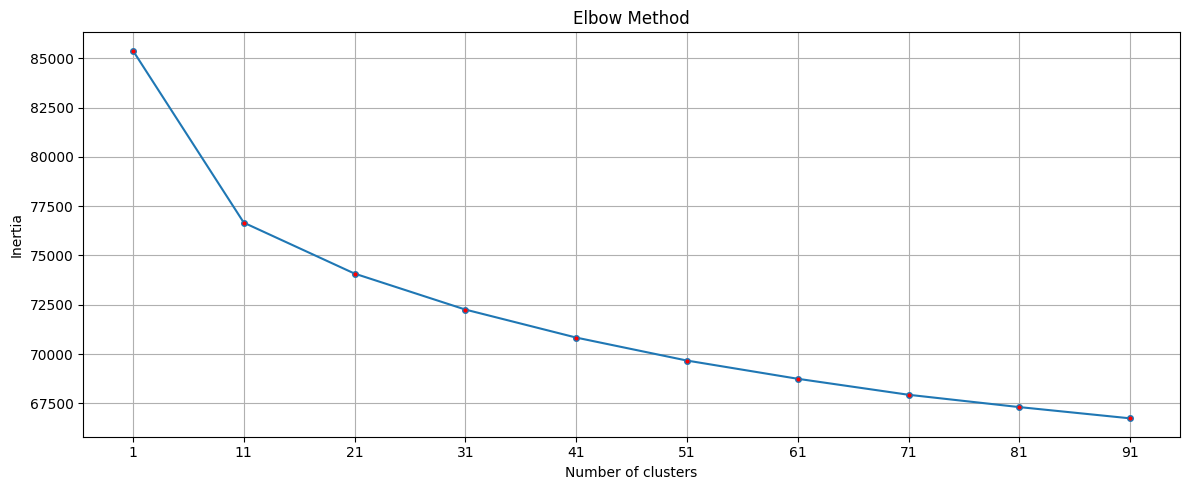

In [ ]:
# We will determine the optimal number of clusters using the elbow method.
k_range = range(1,101,10)
inertia = []
for k in k_range:
    model = KMeans(n_clusters=k,random_state=1)
    model.fit(embeddings)
    inertia.append(model.inertia_)

plt.figure(figsize=(12,5))
plt.plot(k_range,inertia,marker='o',markersize=4,mfc='r',zorder=3)
plt.xticks(k_range)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.tight_layout()
plt.grid(zorder=1)
plt.show()

The optimal value will be approximately 10 clusters.

In [ ]:
# Creating a cluster index.
nlist = 10
d = embeddings.shape[1]
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)

In [ ]:
# Training the index.
index.train(embeddings)

In [ ]:
# Adding the vectors to the index.
index.add(embeddings)

In [ ]:
# Saving the knowledge base to a file.
faiss.write_index(index, "vector_base.idx")

In [ ]:
# Testing the knowledge base.
query = 'Tell me about the most famous football player.'
query_vector = encoder.encode(query,convert_to_numpy=True)
query_vector = query_vector.reshape((1,-1))

In [ ]:
d, indices = index.search(query_vector, 1)

In [ ]:
# The minimum distance between the vector of our query and the vector of the knowledge base.
d

array([[0.9667672]], dtype=float32)

In [ ]:
# Let's see the result.
print(texts[indices[0][0]])

Ronaldo de Assis Moreira (born 21 March 1980), more commonly known as Ronaldinho, or Ronaldinho Gaúcho, is a retired Brazilian footballer. Considered the best player in world football for several years, he is regarded as one of the greatest footballers of all time, and by some, as the greatest ever. He was known for his dribbling, passing, flair, skills, and ability to create and score goals, all prominent characteristics of his early-age background playing futsal. He is the only player ever to have won a World Cup, a Copa América, a Confederations Cup, a Champions League, a Copa Libertadores and a Ballon d'Or.
At club level, he is best known for playing for F.C. Barcelona. After scoring two solo goals in the first 2005–06 El Clásico, he became the second Barcelona player, after Diego Maradona in 1983, to receive a standing ovation from Real Madrid fans at the Santiago Bernabéu. In 2009, he was voted "World Player of the Decade 2000s", ahead of Lionel Messi and Cristiano Ronaldo. In Br

## Conclusion

In this file, I have correctly prepared the data for uploading to the vector database, which improves the accuracy of the final result. I also applied the cluster index technique to search for the corresponding vectors in the knowledge base, which will significantly speed up the inference process.